In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 13,6

# <center> Matplotlib

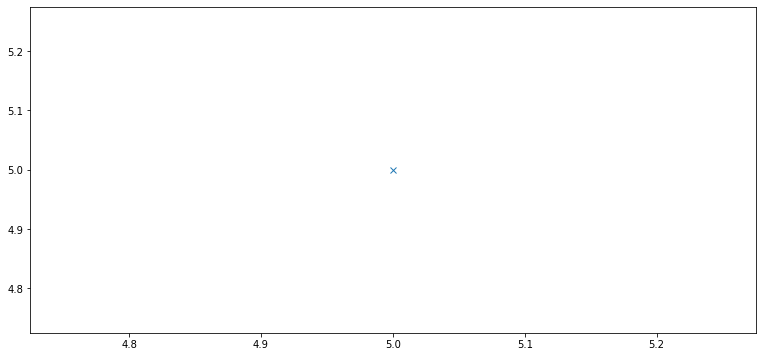

In [4]:
plt.plot(5, 5, 'x')

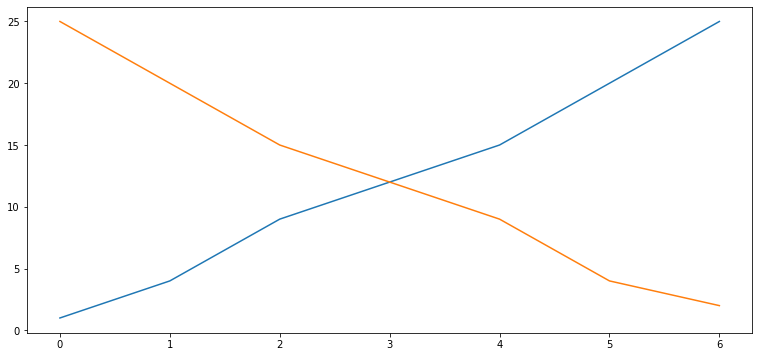

In [5]:
plt.plot([1, 4, 9, 12, 15, 20, 25])
plt.plot([25, 20, 15, 12, 9, 4, 2])

Поработаем с данными о продажах и оценках видео-игр с [Kaggle Datasets](https://www.kaggle.com/ashaheedq/video-games-sales-2019?select=vgsales-12-4-2019.csv).

In [203]:
df = pd.read_csv('video_games_sales.csv')

In [36]:
# df.dropna(subset=['User_Score', 'Critic_Score'], inplace=True)

In [37]:
print(df.shape)

(55792, 23)


In [38]:
df.info()
# что видим?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55792 entries, 0 to 55791
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rank            55792 non-null  int64  
 1   Name            55792 non-null  object 
 2   basename        55792 non-null  object 
 3   Genre           55792 non-null  object 
 4   ESRB_Rating     23623 non-null  object 
 5   Platform        55792 non-null  object 
 6   Publisher       55792 non-null  object 
 7   Developer       55775 non-null  object 
 8   VGChartz_Score  0 non-null      float64
 9   Critic_Score    6536 non-null   float64
 10  User_Score      335 non-null    float64
 11  Total_Shipped   1827 non-null   float64
 12  Global_Sales    19415 non-null  float64
 13  NA_Sales        12964 non-null  float64
 14  PAL_Sales       13189 non-null  float64
 15  JP_Sales        7043 non-null   float64
 16  Other_Sales     15522 non-null  float64
 17  Year            54813 non-null 

In [39]:
# переведем для порядка годы к integer
df['Year'] = df.Year.astype('Int64')

In [40]:
df.describe()

,Rank,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,status,Vgchartzscore
count,55792.000000,0.0,6536.000000,335.000000,1827.000000,19415.000000,12964.000000,13189.000000,7043.000000,15522.000000,54813.000000,55792.0,799.000000
mean,27896.500000,NaN,7.213709,8.253433,1.887258,0.365503,0.275541,0.155263,0.110402,0.044719,2005.659095,1.0,7.425907
std,16105.907446,NaN,1.454079,1.401489,4.195693,0.833022,0.512809,0.399257,0.184673,0.129554,8.355585,0.0,1.384226
min,1.000000,NaN,1.000000,2.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,1970.000000,1.0,2.600000
25%,13948.750000,NaN,6.400000,7.800000,0.200000,0.030000,0.050000,0.010000,0.020000,0.000000,2000.000000,1.0,6.800000
50%,27896.500000,NaN,7.500000,8.500000,0.590000,0.120000,0.120000,0.040000,0.050000,0.010000,2008.000000,1.0,7.800000
75%,41844.250000,NaN,8.300000,9.100000,1.800000,0.360000,0.290000,0.140000,0.120000,0.040000,2011.000000,1.0,8.500000
max,55792.000000,NaN,10.000000,10.000000,82.860000,20.320000,9.760000,9.850000,2.690000,3.120000,2020.000000,1.0,9.600000


In [41]:
df.head()

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,...,NaN,NaN,NaN,NaN,2006,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,...,NaN,NaN,NaN,NaN,1985,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,...,NaN,NaN,NaN,NaN,2008,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg
3,4,PlayerUnknown's Battlegrounds,playerunknowns-battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,...,NaN,NaN,NaN,NaN,2017,13th Nov 18,http://www.vgchartz.com/game/215988/playerunkn...,1,NaN,/games/boxart/full_8052843AmericaFrontccc.jpg
4,5,Wii Sports Resort,wii-sports-resort,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,8.0,...,NaN,NaN,NaN,NaN,2009,NaN,http://www.vgchartz.com/game/24656/wii-sports-...,1,8.8,/games/boxart/full_7295041AmericaFrontccc.jpg


## График
Построим график динамики продажи видеоигр

In [42]:
dynamics_by_region = df[[x for x in df.columns if 'Sales' in x] + ['Year']] \
    .groupby('Year').sum()
dynamics_by_region

,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales
Year,,,,,
1970,1.16,0.45,0.21,0.45,0.05
1973,0.00,0.00,0.00,0.00,0.00
1975,0.00,0.00,0.00,0.00,0.00
1977,2.50,2.34,0.14,0.00,0.02
1978,6.19,5.77,0.36,0.00,0.04
1979,0.31,0.29,0.02,0.00,0.00
1980,2.58,2.41,0.15,0.00,0.02
1981,10.49,9.77,0.62,0.00,0.11
1982,35.69,33.33,1.96,0.00,0.33


In [43]:
# применяем функцию plot из matplotlib
# для каждой дополнительной настройки есть своя функция
plt.plot(dynamics_by_region.index, dynamics_by_region.Global_Sales)
plt.title('Динамика продаж видеоигр')
plt.xlabel('Год')
plt.ylabel('Продажи, млн.')

NameError: NameError: name 'plt' is not defined

In [44]:
# можем использовать цикл, чтобы потсроить графики для каждого региона
for region in [x for x in df.columns if 'Sales' in x]:
    plt.plot(dynamics_by_region.index, dynamics_by_region[region])
    plt.title('Динамика продаж видеоигр')
    plt.xlabel('Год')
    plt.ylabel('Продажи, млн.') 
    plt.legend(dynamics_by_region)

NameError: NameError: name 'plt' is not defined

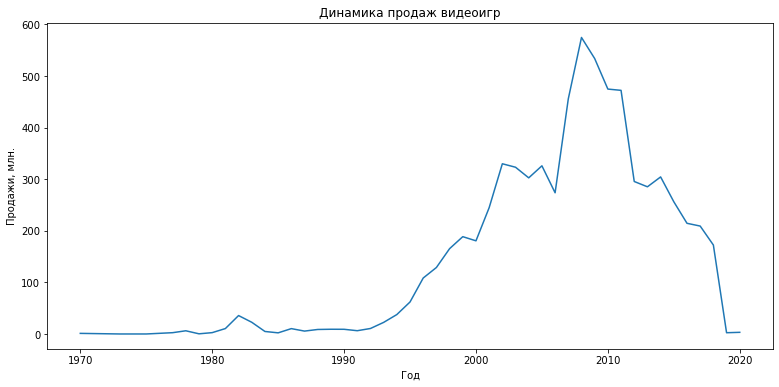

In [45]:
# если работает с табличными структурами, то можем воспользоваться функционалом, 
# встроенным в pandas. Так удобнее
# Метод plot по-умолчанию использует индекс датафрейма для оси Y
# метод plot по-умолчанию строит график
dynamics_by_region['Global_Sales'].plot(title='Динамика продаж видеоигр', 
                                        xlabel='Год', 
                                        ylabel='Продажи, млн.')

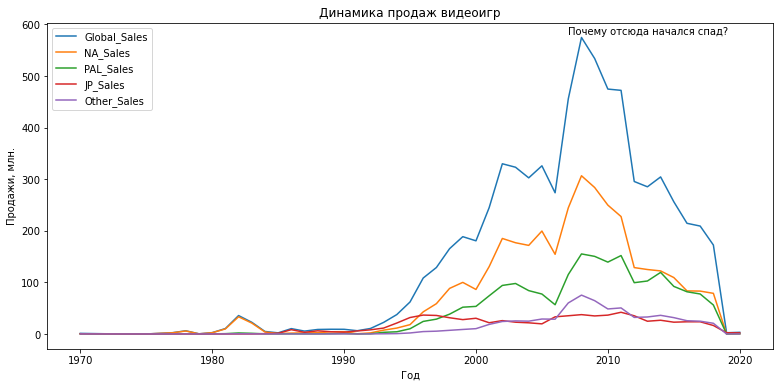

In [46]:
# plot без цикла построит графики для каждого региона (столбца)
# если у plot нету нужных методов, то можно применить функции matplotlib
ax = dynamics_by_region.plot(title='Динамика продаж видеоигр', 
                             xlabel='Год', 
                             ylabel='Продажи, млн.')
ax.text(2007, 580, 'Почему отсюда начался спад?')  
ax.legend(loc='upper left')

## Area chart

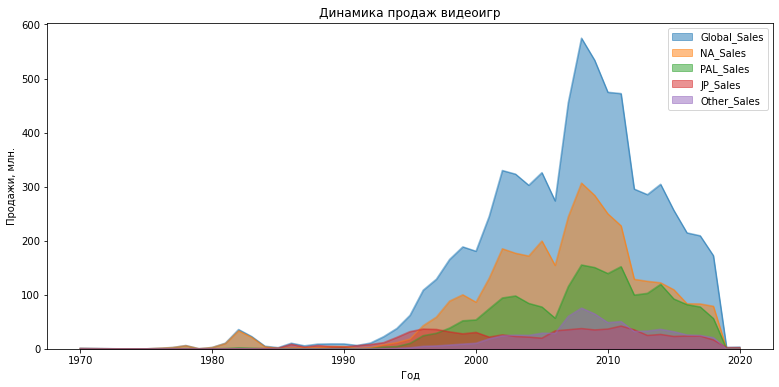

In [189]:
# по-умолчанию  Area chart всегда накопительный
ax = dynamics_by_region.plot(kind='area',
                             stacked=False,
                             title='Динамика продаж видеоигр', 
                             xlabel='Год', 
                             ylabel='Продажи, млн.')

# Гистограммы

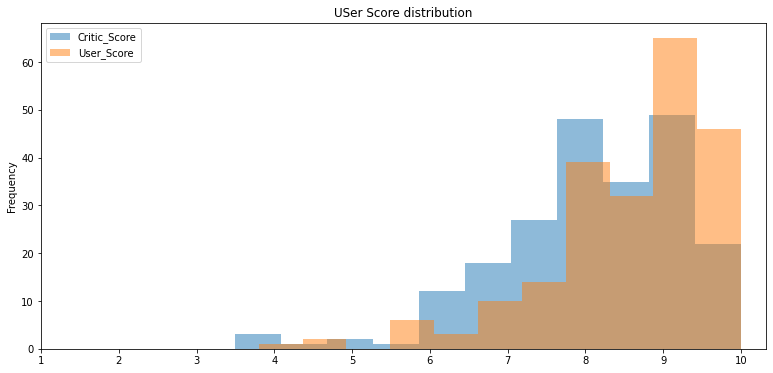

In [48]:
# распределение оценок критиков
ax = df.dropna(subset=['User_Score']).Critic_Score.plot(kind='hist', 
                     bins=11,
                     title='Critic Score distribution',
                     xlabel='Critic score',
                     ylabel='Games',
                     alpha = 0.5,
                     xticks=range(1, 11))
ax.legend(loc='upper left')
# распределение оценок пользователей
# df['User_Score'] = df['User_Score'] / 20
ay = df.dropna(subset=['Critic_Score']).User_Score.plot(kind='hist', 
                   bins=11,
                   title='USer Score distribution',
                   xlabel='USer score',
                   ylabel='Games',
                   alpha = 0.5,
                   xticks=range(1, 11))
ay.legend(loc='upper left')
# print(df.User_Score.count(), df.Critic_Score.count())
# print(df.User_Score.isna().count())

In [49]:
import pandas as pd

print([1, 2] * 5)
df_1 = pd.DataFrame({'one': [1, 2, 3, 4]})
df_2 = pd.DataFrame({'one': [1, 2]})
df_2 += df_2
print(df_2.one.values)

[1, 2, 1, 2, 1, 2, 1, 2, 1, 2]
[2 4]


## Столбчатая диаграмма

In [50]:
# продажи в разрезе платформ
games_by_platforms = df[['Name', 'Platform']].groupby('Platform').count()
games_by_platforms

,Name
Platform,
2600,501
3DO,304
3DS,1192
5200,73
7800,59
...,...
XBL,2115
XOne,1082
ZXS,19


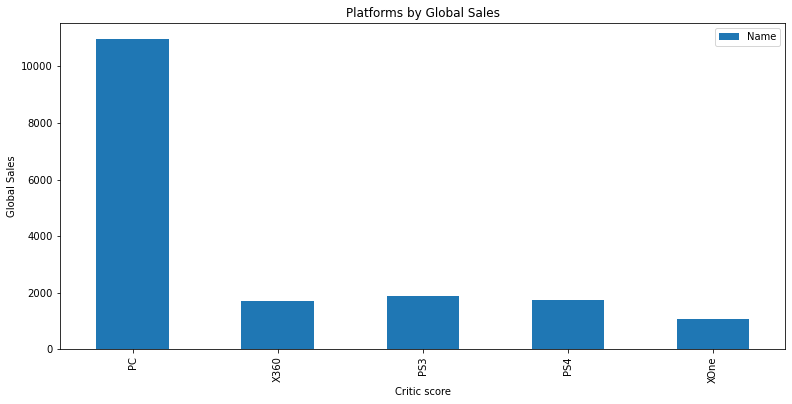

In [51]:
games_by_platforms.loc[['PC', 'X360', 'PS3', 'PS4', 'XOne']].plot(kind='bar', 
                                                                  title='Platforms by Global Sales',
                                                                  xlabel='Critic score',
                                                                  ylabel='Global Sales')

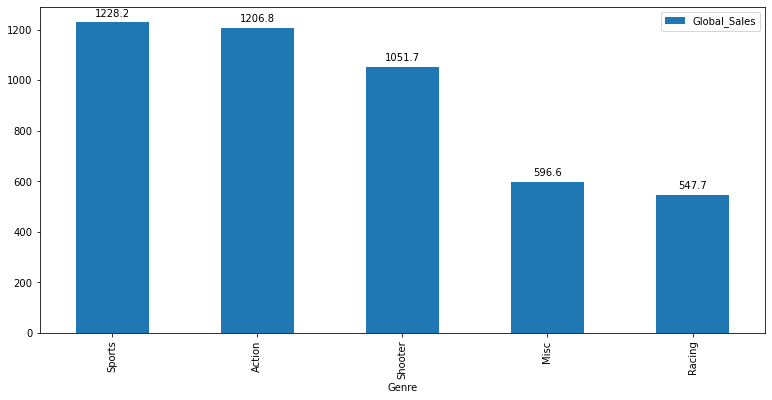

In [52]:
# топ-5 жанров по продажам
top5_genres = df[['Global_Sales', 'Genre']].groupby(by='Genre').sum().sort_values(by='Global_Sales', ascending=False).head(5)
ax = top5_genres.plot(kind='bar')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

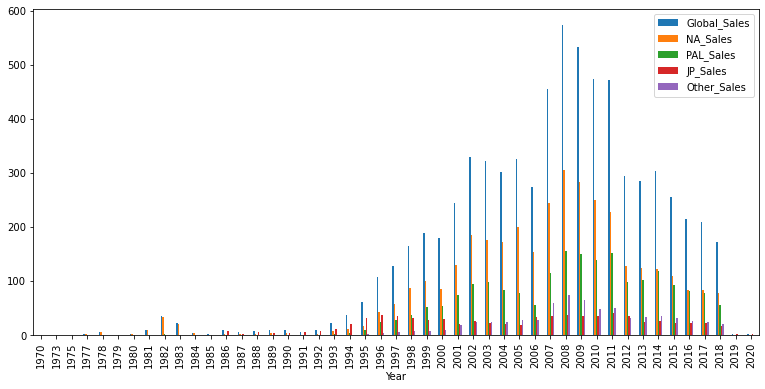

In [66]:
# динамика продаж в разрезе регионов. Выглядит фигово
dynamics_by_region.plot(kind='bar')

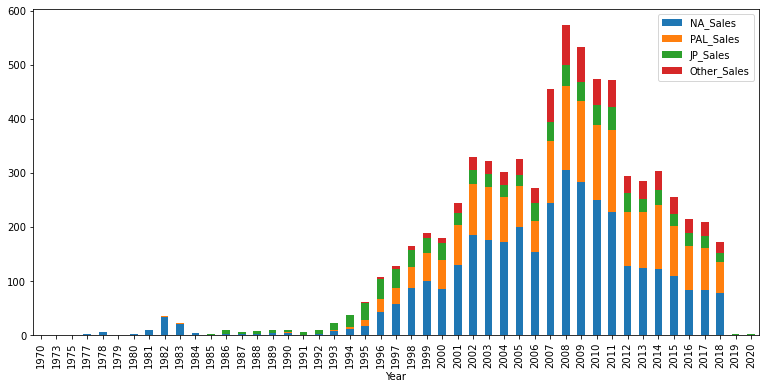

In [67]:
# Сделаем с накоплением!
dynamics_by_region.drop('Global_Sales', axis=1).plot(kind='bar', stacked=True)

## Круговая диаграмма

In [0]:
# количество игр по платформам
pie_data = df.Platform.value_counts().sort_values(ascending = False).head(10)
ax = pie_data.plot(kind='pie',
                   title='Quantity of games by platforms')

In [0]:
# количество игр по платформам (берем только топ-5)
top_platforms = df.Platform.value_counts().sort_values(ascending = False).head(5)
ax = top_platforms.plot(kind='pie')
ax.legend()

## Boxplot

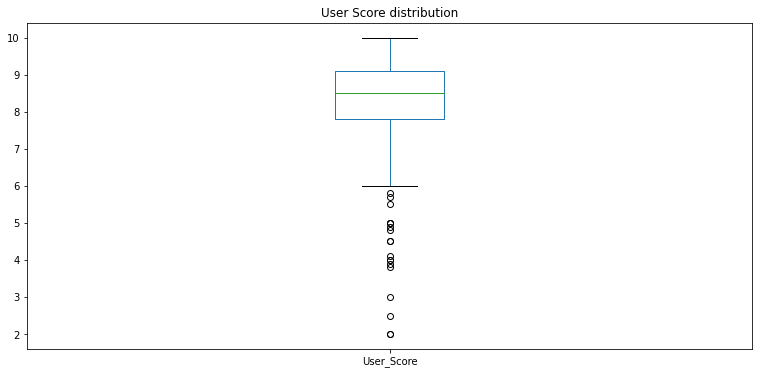

In [68]:
# очень хорошо подходит для поиска выбросов!
df.User_Score.plot(kind='box',
                   title='User Score distribution')

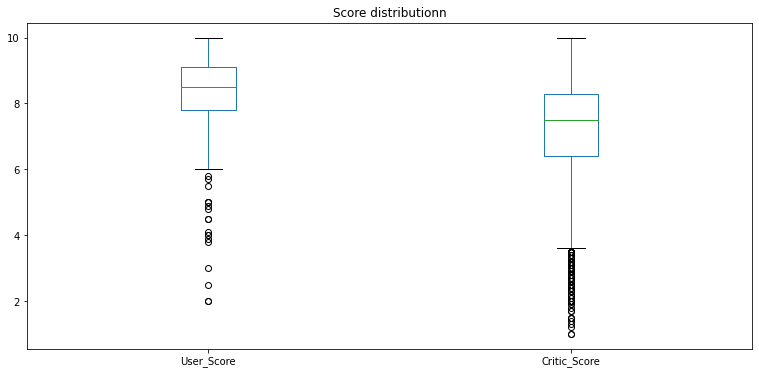

In [69]:
df[['User_Score', 'Critic_Score']].plot(kind='box',
                                        title='Score distributionn')

## Точечная диаграмма

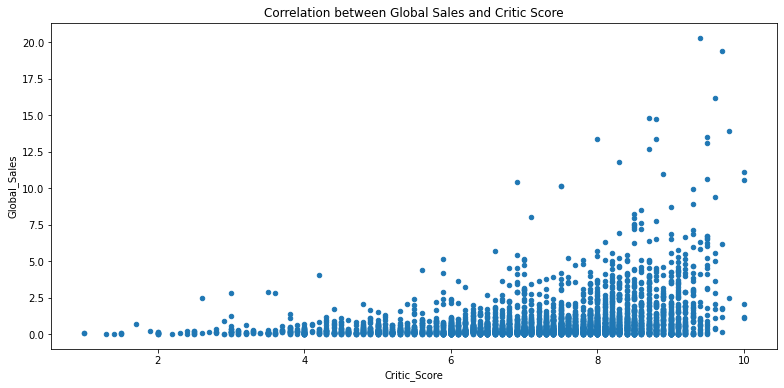

In [70]:
# посмотрим на взимосвязь оценок и продаж
df.plot(kind='scatter', 
        x='User_Score', 
        y='Global_Sales', 
        title='Correlation between Global Sales and User Score')
plt.show()
df.plot(kind='scatter', 
        x='Critic_Score', 
        y='Global_Sales', 
        title='Correlation between Global Sales and Critic Score')

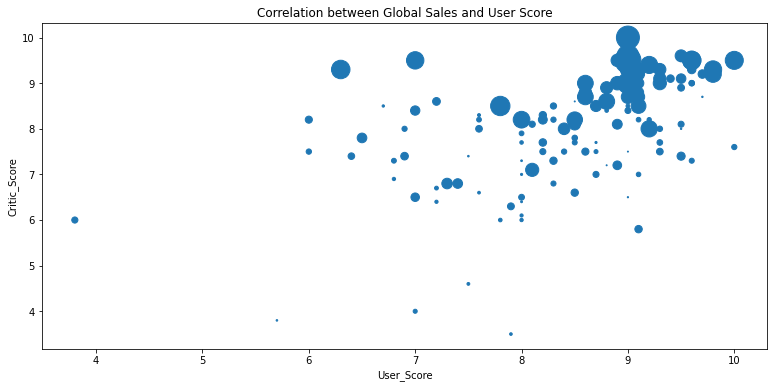

In [74]:
# добавим третью ось
df.plot(kind='scatter', 
        x='User_Score', 
        y='Critic_Score', 
        s=df.Global_Sales*50,
        title='Correlation between Global Sales and User Score',
       )

## Стилизация таблиц

In [75]:
# выведем информацию о топ-10 издателях по продажам
top_developers_df = df.groupby('Developer')[['Global_Sales']].sum()\
    .sort_values('Global_Sales', ascending=False).head(10)
    
top_developers_df

,Global_Sales
Developer,
EA Canada,277.87
EA Tiburon,186.19
Ubisoft Montreal,172.96
Treyarch,150.19
Traveller's Tales,149.60
Konami,119.94
Infinity Ward,118.97
Rockstar North,116.91
Capcom,99.80


In [76]:
top_developers_df.style.bar(align='mid')

,Global_Sales
Developer,
EA Canada,277.870000
EA Tiburon,186.190000
Ubisoft Montreal,172.960000
Treyarch,150.190000
Traveller's Tales,149.600000
Konami,119.940000
Infinity Ward,118.970000
Rockstar North,116.910000
Capcom,99.800000


# <center> Seaborn

In [204]:
import seaborn as sns

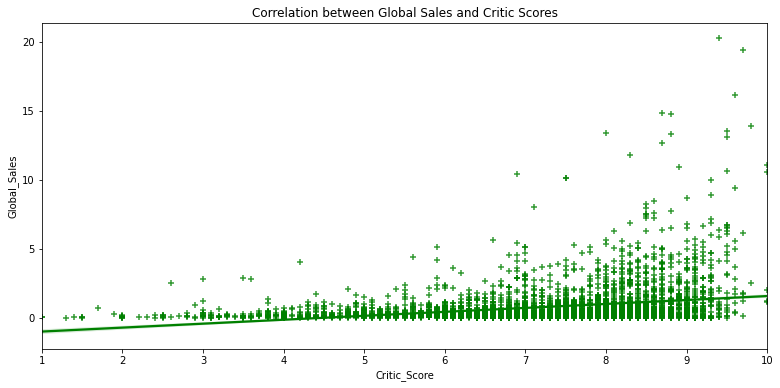

In [205]:
# посмотрим зависимость продаж и оценок критиков
ax = sns.regplot(data=df, x='Critic_Score', y='Global_Sales', color='green', marker='+')
ax.set_title('Correlation between Global Sales and Critic Scores')

C помощью `seaborn` можно построить достаточно сложные визуализации, которые были бы очень сложны для представления в коде при использовании `matplotlib`. Рассмотрим часть из них.

Посмотрим на **распределение оценок критиков `Critic_Score`**. Для этого построим __`distplot`__. По-умолчанию на визуализации отображается гистограмма и [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation).

/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


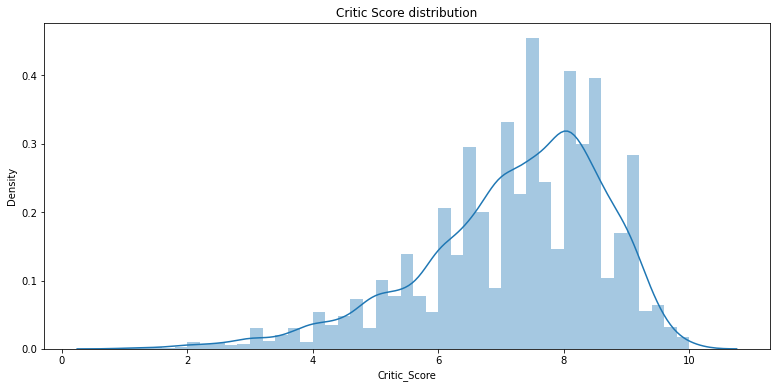

In [206]:
ax = sns.distplot(df.Critic_Score)
ax.set_title('Critic Score distribution')

Для того чтобы подробнее посмотреть на взаимосвязь двух численных признаков можно использовать __`joint_plot`__ – это гибрид `scatter plot` и `histogram`. Посмотрим на то, как связаны между собой **оценка критиков `Critic_Score` и оценка пользователя `User_Score`**.

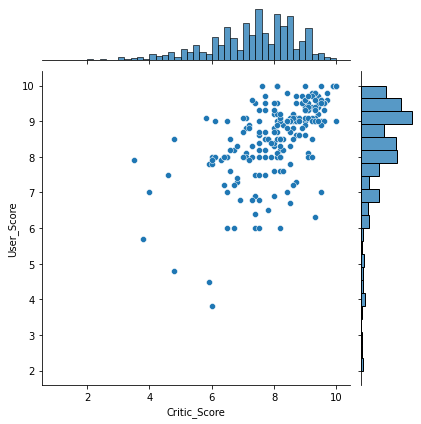

In [207]:
sns.jointplot(x='Critic_Score', y='User_Score', 
              data=df, kind='scatter')

**pair plot (scatter plot matrix)** поможет нам посмотреть на одной картинке, как связаны между собой различные признаки в наборе данных

In [202]:
sns.pairplot(df[['Global_Sales', 'Critic_Score', 'User_Score', 'Year']])

KeyError: KeyError: "None of [Index(['Global_Sales', 'Critic_Score', 'User_Score', 'Year'], dtype='object')] are in the [columns]"

Давайте **сравним пользовательские оценки игр для топ-5 крупнейших игровых платформ** при помощи `boxplot`.

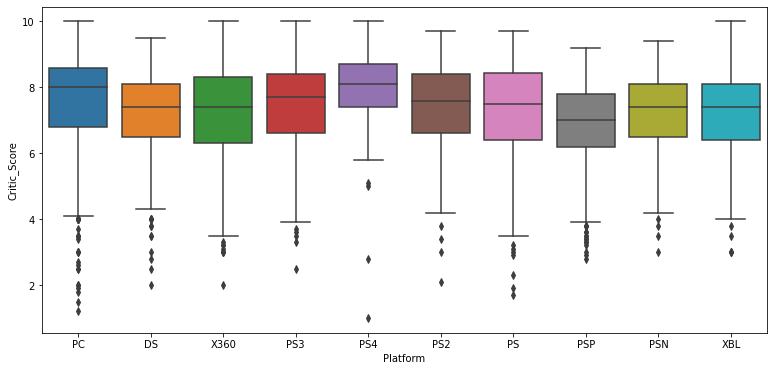

In [208]:
top_platforms = df.Platform.value_counts().sort_values(ascending = False).head(10).index.values
top_platforms
sns.boxplot(x="Platform", y="Critic_Score", 
            data=df[df.Platform.isin(top_platforms)])

`Heat map` позволяет посмотреть на распределение какого-то численного признака по двум категориальным. Визуализируем **суммарные продажи игр по жанрам и игровым платформам**.

In [209]:
platform_genre_sales = df[df.Platform.isin(top_platforms)].pivot_table(
                        index='Platform', 
                        columns='Genre', 
                        values='Global_Sales', 
                        aggfunc=sum).fillna(0)

platform_genre_sales

Genre,Action,Action-Adventure,Adventure,Board Game,Education,Fighting,MMO,Misc,Music,Party,Platform,Puzzle,Racing,Role-Playing,Sandbox,Shooter,Simulation,Sports,Strategy,Visual Novel
Platform,,,,,,,,,,,,,,,,,,,,
DS,65.62,0.94,65.19,0.0,0.0,6.71,0.00,71.56,0.00,0.00,26.03,42.37,13.77,35.23,0.0,7.15,89.04,30.57,15.47,0.00
PC,11.26,2.79,7.62,0.0,0.0,0.40,3.15,9.61,0.70,0.00,0.54,0.94,4.19,20.05,0.0,41.17,56.03,12.45,27.64,0.00
PS,82.44,0.00,36.40,0.0,0.0,62.70,0.00,45.50,0.00,0.00,57.78,12.40,83.35,38.04,0.0,40.84,20.50,124.18,22.93,0.00
PS2,185.57,0.00,45.91,0.0,0.0,73.21,0.32,92.32,0.00,0.08,71.04,5.33,129.85,54.11,0.0,109.98,43.86,276.79,15.18,0.07
PS3,212.58,32.51,28.01,0.0,0.0,48.65,1.42,60.76,3.81,0.04,31.60,1.79,55.82,60.67,0.0,200.84,8.30,153.41,4.91,0.60
PS4,117.48,51.18,13.87,0.0,0.0,17.71,3.63,12.97,5.46,0.71,19.22,1.01,24.78,54.38,0.0,145.19,6.46,108.84,1.62,0.58
PSN,0.11,0.00,0.17,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.16,0.00,2.82,0.00,0.0,0.59,0.00,0.03,0.02,0.00
PSP,48.39,0.08,17.40,0.0,0.0,15.08,0.00,14.62,0.38,0.47,20.17,5.68,34.88,26.89,0.0,19.47,6.76,42.54,10.09,0.81
X360,165.88,25.27,28.04,0.0,0.0,37.47,0.00,58.43,9.40,0.22,17.11,1.70,66.32,67.40,0.0,249.28,10.98,142.89,8.88,0.22


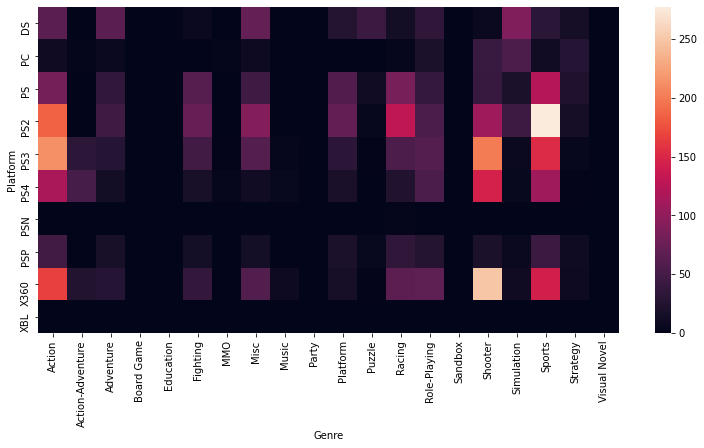

In [210]:
sns.heatmap(platform_genre_sales)

# Визуализация данных
Для визуализации выбран [набор данных о Covid-19](https://www.kaggle.com/hgultekin/covid19-coronavirus-data-weekly), взятый с Kaggle. 

In [44]:
from pylab import rcParams
import pandas as pd

df = pd.read_json('covid-19.json')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25052 entries, 0 to 25051
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country           25052 non-null  object 
 1   country_code      24272 non-null  object 
 2   continent         25052 non-null  object 
 3   population        25052 non-null  int64  
 4   indicator         25052 non-null  object 
 5   weekly_count      25052 non-null  int64  
 6   year_week         25052 non-null  object 
 7   cumulative_count  25052 non-null  int64  
 8   source            25052 non-null  object 
 9   rate_14_day       24612 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 1.9+ MB


In [45]:
# Первичный анализ
print(df.indicator.unique())
print(len(df.year_week.unique()))
print(len(df[~df.country.str.contains(r'\(total\)')].country.unique()))
print(len(df.continent.unique()))

['cases' 'deaths']
65
214
5


## 1. Топ 15 стран по количеству заболевших

In [46]:
max_total_cases = df[~df.country.str.contains(r'\(total\)') & df.indicator.str.contains('cases')][['cumulative_count', 'country']].groupby('country').max().sort_values('cumulative_count')

In [47]:
from pylab import xlim

In [48]:
# Убираем подпись оси Y
max_total_cases.index.name = None
# Изменяем единицы измерения
max_total_cases['cumulative_count'] = max_total_cases['cumulative_count'] / 1000000

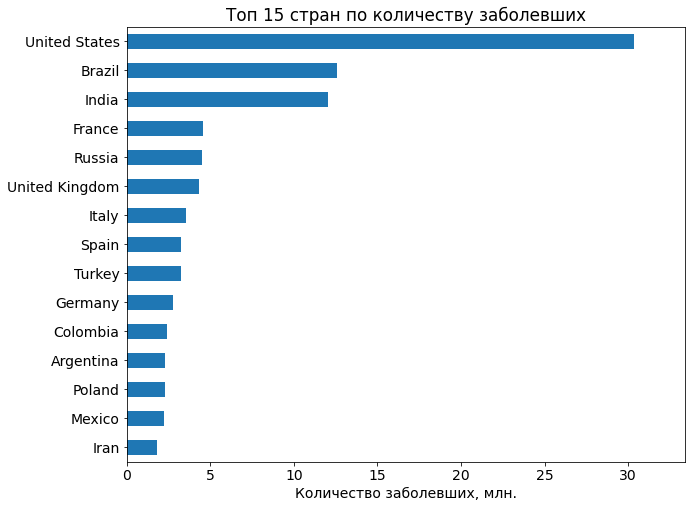

In [49]:
rcParams['font.size'] = 14
ax = max_total_cases.iloc[-15:]['cumulative_count'].plot(kind='barh',
                                                #    y=max_total_cases.index[:15],
                                                #    width=max_total_cases.cumulative_count[:15],
                                                   title='Топ 15 стран по количеству заболевших',
                                                #    xlabel='Страны',
                                                   figsize = (10,8))
xlim(0, max_total_cases['cumulative_count'].max() * 1.1)
ax.set_xlabel('Количество заболевших, млн.')                                        

### Выводы
На данной (столбчатой) диаграмме отображены данные по 15 странам с наибольшим количеством заболевших Covid-19 на данный момент.
На диаграмме видно, что есть несколько стран (Америка, Бразилия, Индия) с количеством заболевших, в несколько раз больше, чем у ближайших соседей.

## 2. Скорость роста заболеваимости/смертности по континентам

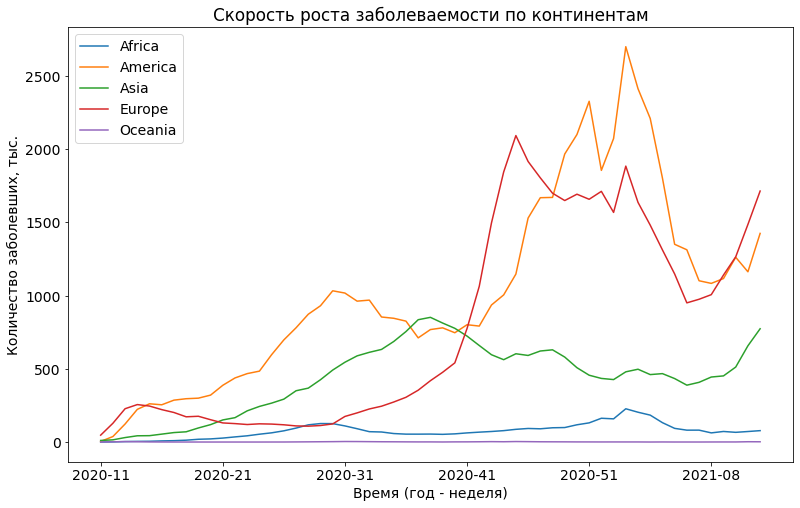

In [50]:
speed_by_continents = df[~df.country.str.contains(r'\(total\)') & df.indicator.str.contains('cases')].pivot_table(index='year_week', columns='continent', values='weekly_count', aggfunc='sum')
speed_by_continents = speed_by_continents / 1000
ax = speed_by_continents.iloc[10:].plot(title='Скорость роста заболеваемости по континентам', 
                             xlabel='Время (год - неделя)', 
                             ylabel='Количество заболевших, тыс.',
                             figsize = (13,8))
ax.legend(loc='upper left')

### Выводы
На диаграмме показана динамика роста заболеваемости по континентам. На данный момент лидерами по количеству заболеваний в неделю являются Американский и Европейские регионы. Если до сентября 2020 года лидерами были Америка и Азия, то после сентября показатели Азиантского региона начали падать, тогда как Европейского - резко расти. Также графики Американского и Европейского регионов очень похожи, что может свидетельствовать: 1) о миграции населения между данными регионами; 2) о наличии сходных ситуаций, факторов - которые повышают вероятность заражения вирусом.
Африканскому региону свойственна меньшая скорость заболеваемости и ее рост заметен лишь на периоде времени в 1 год.
Странам Океании свойственна меньшая скорость роста заболеваемости и рост ее на протяжении года, в сравнении с другими регионами, незначителен.

## 3. Зависимость между численностью населения и скоростью роста заболеваемости

In [22]:
pop_count_correlation = df[~df.country.str.contains(r'\(total\)') & df.indicator.str.contains('cases')].copy()
pop_count_correlation['population'] /= 1000000
pop_count_correlation['weekly_count'] /= 1000

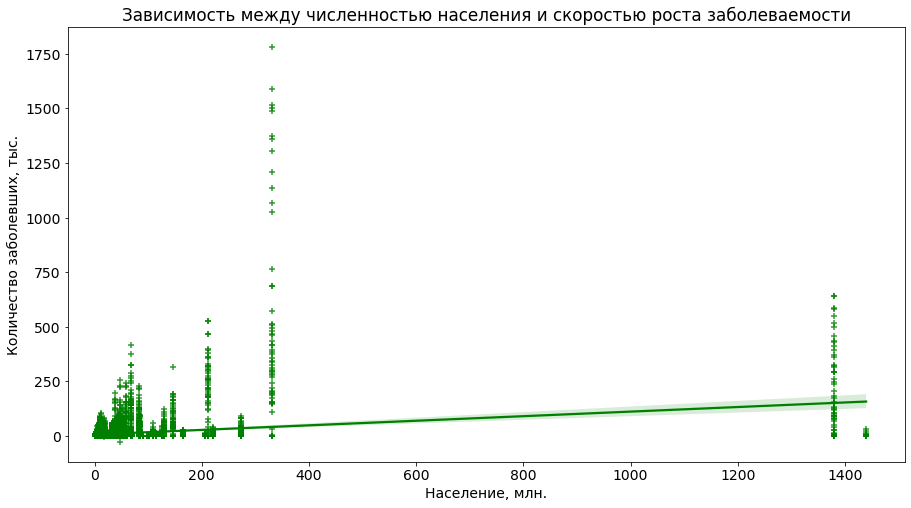

In [52]:
import seaborn as sns
rcParams['figure.figsize'] = 15,8

ax = sns.regplot(data=pop_count_correlation, x='population', y='weekly_count', color='green', marker='+')
ax.set_title('Зависимость между численностью населения и скоростью роста заболеваемости')
ax.set_xlabel('Население, млн.')
ax.set_ylabel('Количество заболевших, тыс.')
ax.set_xlim(-50, pop_count_correlation.population.max() * 1.05)

### Выводы
На диаграмме изображена зависимость количества заболевших от численности населения страны. Можно видеть, что явной линейной зависимости между этими величинами нет, хотя и есть некоторое приближение к этому.
Особо показательны(информативны) как раз случаи, не укладывающиеся в линейную зависимость: страны с населением в районе 50-100 млн. имеют большую скорость заболеваемости, чем некоторые страны с населением в 200+ млн. и 1400+ млн. Для таких ситуаций возможно большое количество трактовок - начиная с различной плотности населения и заканчивая различиями в строгости принятых мер.

## 4. Связь между скоростью роста числа заболевших и умерших

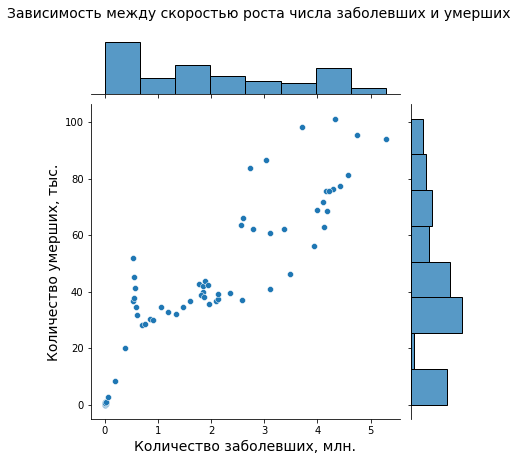

In [41]:
cases_death_correlation = df[~df.country.str.contains(r'\(total\)')].pivot_table(index='year_week', columns='indicator', values='weekly_count', aggfunc='sum')
cases_death_correlation['deaths'] /= 1000
cases_death_correlation['cases'] /= 1000000

az = sns.jointplot(x='cases', y='deaths', data=cases_death_correlation, kind='scatter')
az.fig.suptitle('Зависимость между скоростью роста числа заболевших и умерших', y=1.05, fontsize=14)
az.set_axis_labels('Количество заболевших, млн.', 'Количество умерших, тыс.', fontsize=14)

### Выводы
Изображенная на диаграмме зависимость между скоростью числа заболевших и умерших очень похожа на линейную: в целом, с увеличением числа заболевших увеличивается количество умерших.
Однако на интервалах между 30 и 40 тыс., а также между 60 и 70 тыс. умерших количество заболевших колеблется от 0,5 до 3 млн. в первом случае и от 2,5 до 4 млн. во втором. Причины этого могут быть самой разной природы: 1) особенность данных/описываемого предмета - между заболеванием и смертью есть временной промежуток, который мы не учитываем. Соответственно, рост количества умерших в период спада скорости роста заболеваемости скорее всего связан с тем, что умирают не вновь заболевшие, а те, что заразились некоторое количество времени назад; 2) аггрегирование данных - учитывая, что на данной диаграмме рассматривается суммарное количество случаев смертей/заболеваний по всему миру, могут иметь место следующие факторы: а) период спада заболеваемости в одном регионе может совпадать с периодом роста в другом; б) разница в уровне развития здравоохранения и доступности мед. помощи гражданам и другие.